# Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set
import warnings
import re
from pandas.io import gbq
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import sparse

# Get the Data

In [110]:
chicago_data = """
                    SELECT unique_key, date, primary_type, location_description, 
                            arrest, domestic, community_area, year
                    FROM `gdac-327115.Chicago.chicago2`
                    WHERE year >= 2011
               """
chicago_data = gbq.read_gbq(chicago_data, project_id="gdac-327115")

In [111]:
#Read in an Excel file with a one to one mapping between Chicago community areas and districts
chicago_districts = pd.read_excel("ChicagoCommunityAreas.xlsx")

In [112]:
#Data type can't be joined on an int
chicago_districts.community_area = chicago_districts["community_area"].astype("string")
chicago_data.community_area = chicago_data["community_area"].astype("string")

In [113]:
#Outer join the two data sets
chicago = chicago_data.merge(chicago_districts, how="outer", left_on="community_area", right_on="community_area", )

In [114]:
#Check data types
chicago.dtypes

unique_key                            Int64
date                    datetime64[ns, UTC]
primary_type                         object
location_description                 object
arrest                              boolean
domestic                            boolean
community_area                       string
year                                  Int64
district_name                        object
community_name                       object
dtype: object

In [7]:
#Change the object data types to categorical
chicago.loc[:, chicago.dtypes == "object"] = chicago.select_dtypes(["object"]).apply(lambda x: x.astype("category"))

In [8]:
#Drop the community area variable since we have a community name variable
chicago.drop("community_area", axis = 1, inplace = True)

### Explore first few rows

In [10]:
chicago.head()

,unique_key,date,primary_type,location_description,arrest,domestic,year,latitude,longitude,district_name,community_name
0,11228094,2017-11-20 15:00:00+00:00,DECEPTIVE PRACTICE,POOL ROOM,False,False,2017,NaN,NaN,Far North,NORTH PARK
1,12135292,2020-08-13 12:00:00+00:00,DECEPTIVE PRACTICE,BANK,False,False,2020,41.993402,-87.712280,Far North,NORTH PARK
2,8905294,2012-11-27 17:30:00+00:00,PUBLIC PEACE VIOLATION,RESTAURANT,False,False,2012,41.978265,-87.708742,Far North,NORTH PARK
3,8805120,2012-09-17 00:30:00+00:00,DECEPTIVE PRACTICE,TAXICAB,False,False,2012,41.985277,-87.713827,Far North,NORTH PARK
4,9030552,2013-02-21 00:00:00+00:00,CRIM SEXUAL ASSAULT,RESIDENCE,False,True,2013,41.994323,-87.720213,Far North,NORTH PARK


In [11]:
#Check the number of rows and columns
chicago.shape

(2971810, 11)

# Split the Data into a Training Set and Test Set

In [78]:
chicago_train = chicago.loc[chicago["year"] != 2021]
chicago_test = chicago.loc[chicago["year"] == 2021]

In [20]:
#Check if the test set contains data from the full year
chicago_test.loc[:, "date"].dt.month. \
                                value_counts(). \
                                reset_index(). \
                                rename(columns={"index":"Month", "date":"Count"}). \
                                sort_values(by = "Month")

,Month,Count
5,1,16008
8,2,12852
6,3,15709
7,4,15279
4,5,17493
2,6,18468
0,7,18898
3,8,18110
1,9,18632
9,10,5507


# Data Exploration and Cleaning

In [22]:
#Check the total number of missing values for each variable
chicago_train.isnull().sum()

unique_key                  0
date                        0
primary_type                0
location_description     7844
arrest                      0
domestic                    0
year                        0
latitude                26843
longitude               26843
district_name             218
community_name            218
dtype: int64

In [21]:
#Check to make sure there are no duplicate incidents based on the "unique key" variable
assert len(chicago_train["unique_key"].unique()) == chicago_train.shape[0]

### Cleaning Primary Type Variable

In [23]:
#Quick reference on the number of missing values
chicago_train["primary_type"].isnull().sum()

0

In [10]:
#Examine the different crime types listed
chicago_train["primary_type"].value_counts()

THEFT                                636007
BATTERY                              512318
CRIMINAL DAMAGE                      299943
NARCOTICS                            222406
ASSAULT                              189549
OTHER OFFENSE                        171368
DECEPTIVE PRACTICE                   167709
BURGLARY                             152532
MOTOR VEHICLE THEFT                  120013
ROBBERY                              108092
CRIMINAL TRESPASS                     69971
WEAPONS VIOLATION                     45871
OFFENSE INVOLVING CHILDREN            23359
PUBLIC PEACE VIOLATION                21829
PROSTITUTION                          12438
CRIM SEXUAL ASSAULT                   12334
INTERFERENCE WITH PUBLIC OFFICER      11793
SEX OFFENSE                           10771
HOMICIDE                               5669
ARSON                                  4482
GAMBLING                               3507
LIQUOR LAW VIOLATION                   3407
CRIMINAL SEXUAL ASSAULT         

It appears "CRIM SEXUAL ASSAULT" should be merged into "CRIMINAL SEXUAL ASSAULT". We'll also merge the three various "Non-criminal" categories into one category. We'll do the same thing for the "OTHER NARCOTIC VIOLATION" category. Finally, we'll move "RITUALISM" into the "OTHER" since it has only one occurence. Let's collect all of these changes into one function. 

In [11]:
def crime_type_cleaner(df):
    """
    This function cleans the primary_type column in place. 
    
    df: DataFrame with primary_type column
    
    returns: None
    """
    df.loc[:, "primary_type"].replace(["CRIM SEXUAL ASSAULT"], "CRIMINAL SEXUAL ASSAULT", inplace = True)

    df.loc[:, "primary_type"].replace(["OTHER NARCOTIC VIOLATION"], "NARCOTICS", inplace = True)

    df.loc[:, "primary_type"].replace(["NON - CRIMINAL", "NON-CRIMINAL (SUBJECT SPECIFIED)"], "NON-CRIMINAL", inplace = True)

    df.loc[:, "primary_type"].replace(["RITUALISM"], "OTHER OFFENSE", inplace = True)
   

In [29]:
#Clean the primary type variable
crime_type_cleaner(chicago_train)
#Check the cleaned variable
chicago_train["primary_type"].value_counts()

THEFT                                636007
BATTERY                              512318
CRIMINAL DAMAGE                      299943
NARCOTICS                            222467
ASSAULT                              189549
OTHER OFFENSE                        171369
DECEPTIVE PRACTICE                   167709
BURGLARY                             152532
MOTOR VEHICLE THEFT                  120013
ROBBERY                              108092
CRIMINAL TRESPASS                     69971
WEAPONS VIOLATION                     45871
OFFENSE INVOLVING CHILDREN            23359
PUBLIC PEACE VIOLATION                21829
CRIMINAL SEXUAL ASSAULT               14850
PROSTITUTION                          12438
INTERFERENCE WITH PUBLIC OFFICER      11793
SEX OFFENSE                           10771
HOMICIDE                               5669
ARSON                                  4482
GAMBLING                               3507
LIQUOR LAW VIOLATION                   3407
KIDNAPPING                      

### Cleaning Location Description Variable

In [13]:
#Check the number of missing values
chicago_train["location_description"].isnull().sum()

7844

In [14]:
#Look at which rows are missing
chicago_train.loc[chicago_train["location_description"].isnull()]

,unique_key,date,primary_type,location_description,arrest,domestic,year,latitude,longitude,district_name,community_name
192,10625982,2015-08-01 16:20:00+00:00,DECEPTIVE PRACTICE,NaN,False,False,2015,NaN,NaN,Far North,NORTH PARK
285,12185129,2020-09-28 21:37:00+00:00,DECEPTIVE PRACTICE,NaN,False,False,2020,41.987639,-87.710214,Far North,NORTH PARK
2019,11489624,2018-10-26 15:05:00+00:00,DECEPTIVE PRACTICE,NaN,False,False,2018,41.994360,-87.723939,Far North,NORTH PARK
2034,12018775,2020-03-26 14:00:00+00:00,DECEPTIVE PRACTICE,NaN,False,False,2020,41.974920,-87.706215,Far North,NORTH PARK
2042,10596491,2016-06-16 13:00:00+00:00,DECEPTIVE PRACTICE,NaN,False,False,2016,41.985369,-87.712605,Far North,NORTH PARK
...,...,...,...,...,...,...,...,...,...,...,...
2970607,10465221,2016-03-24 14:25:00+00:00,DECEPTIVE PRACTICE,NaN,False,False,2016,41.982365,-87.662518,Far North,EDGEWATER
2970615,12114559,2020-07-23 11:58:00+00:00,DECEPTIVE PRACTICE,NaN,False,False,2020,41.991336,-87.656851,Far North,EDGEWATER
2970618,10883083,2017-03-19 11:55:00+00:00,DECEPTIVE PRACTICE,NaN,False,False,2017,NaN,NaN,Far North,EDGEWATER
2970632,10852091,2017-02-16 17:15:00+00:00,DECEPTIVE PRACTICE,NaN,False,False,2017,41.982755,-87.662528,Far North,EDGEWATER


Looks like there might be some relationship between the missing locations and the type of crime committed. Let's further explore this. 

In [36]:
#Look at the counts of the primary type variable with the data filtered to those values of location that are missing
chicago_train.loc[chicago_train["location_description"].isnull()]["primary_type"].value_counts()

DECEPTIVE PRACTICE                   7124
THEFT                                 704
BURGLARY                                5
ROBBERY                                 4
BATTERY                                 2
CRIMINAL DAMAGE                         2
OTHER OFFENSE                           1
ARSON                                   1
CRIMINAL SEXUAL ASSAULT                 1
SEX OFFENSE                             0
NON-CRIMINAL                            0
RITUALISM                               0
PUBLIC PEACE VIOLATION                  0
PUBLIC INDECENCY                        0
PROSTITUTION                            0
STALKING                                0
OTHER NARCOTIC VIOLATION                0
OFFENSE INVOLVING CHILDREN              0
OBSCENITY                               0
NON-CRIMINAL (SUBJECT SPECIFIED)        0
MOTOR VEHICLE THEFT                     0
NON - CRIMINAL                          0
NARCOTICS                               0
ASSAULT                           

It appears that nearly all missing values for location description have a primary type that is labeled as "DECEPTIVE PRACTICE". Let's see what the non-missing values for location description have for their corresponding "DECEPTIVE PRACTICE" values.

In [24]:
#Create a boolean mask that filters the data to non-missing locations with a primary type of "DECEPTIVE PRACTICE"
mask = (chicago_train["location_description"].notnull()) & (chicago_train["primary_type"] == "DECEPTIVE PRACTICE")
chicago_train.loc[mask]["location_description"].value_counts()

RESIDENCE                54361
APARTMENT                17232
OTHER                    16680
STREET                    8369
BANK                      6910
                         ...  
PORCH                        0
POOLROOM                     0
EXPRESSWAY EMBANKMENT        0
FARM                         0
YMCA                         0
Name: location_description, Length: 197, dtype: int64

Thus, it appears that the "RESIDENCE" location occurrs the most for non-missing "DECEPTIVE PRACTICE" crimes. Therefore, we can impute the missing values for location that have the corresponding crime as "DECEPTIVE PRACTICE" with "RESIDENCE".  

Let's do the same process for the "THEFT" crime

In [23]:
#Create a boolean mask that filters the data to non-missing locations with a primary type of "THEFT"
mask = (chicago_train["location_description"].notnull()) & (chicago_train["primary_type"] == "THEFT")
chicago_train.loc[mask]["location_description"].value_counts()

STREET                152284
RESIDENCE              58720
APARTMENT              41793
SMALL RETAIL STORE     35004
DEPARTMENT STORE       32695
                       ...  
ELEVATOR                   0
DRIVEWAY                   0
SCHOOL YARD                0
CTA PROPERTY               0
YMCA                       0
Name: location_description, Length: 197, dtype: int64

Now, it appears that the "STREET" location is the most occurring for non-missing "THEFT" crimes. Let's impute the missing values for location that have the corresponding crime as "THEFT" with "STREET". 

Finally, we'll collect the remaining crimes into one group due to their low counts and check what crime is most occurring for the group.

In [37]:
crime_type = ["BURGLARY", "ROBBERY", "BATTERY", "CRIMINAL DAMAGE", "ARSON", "CRIMINAL SEXUAL ASSAULT", "OTHER OFFENSE"]
mask = (chicago_train["primary_type"].isin(crime_type)) & (chicago_train["location_description"].notnull())
chicago_train.loc[mask, ["location_description"]].value_counts()

location_description
RESIDENCE               277616
APARTMENT               248008
STREET                  235210
SIDEWALK                125040
RESIDENCE-GARAGE         35372
                         ...  
PARKING LOT                  0
CLUB                         0
OFFICE                       0
NURSING HOME                 0
YMCA                         0
Length: 197, dtype: int64

Again, it looks like "RESIDENCE" is the most occuring location for the group of crimes when location is not missing. Thus, we can impute the missing location values for the group of crimes as "RESIDENCE". 

We'll collect all of these missing value imputations into one function

In [38]:
def location_imputer(df):
    """
    This function imputes missing values in the location_description column by setting the missing value to the value that 
    occurs most in the primary_type column in place
    
    df: DataFrame that contains the location_description column
    
    returns: None
    """
    mask = (df.loc[:, "primary_type"] == "DECEPTIVE PRACTICE") & (df.loc[:, "location_description"].isnull())
    df.loc[mask, ["location_description"]] = "RESIDENCE"
    
    mask = (df.loc[:, "primary_type"] == "THEFT") & (df.loc[:, "location_description"].isnull())
    df.loc[mask, ["location_description"]] = "STREET"
    
    crime_type = ["BURGLARY", "ROBBERY", "BATTERY", "CRIMINAL DAMAGE", "ARSON", "CRIMINAL SEXUAL ASSAULT", "OTHER OFFENSE"]
    mask = (df.loc[:, "primary_type"].isin(crime_type)) & (df.loc[:, "location_description"].isnull())
    df.loc[mask, ["location_description"]] = "RESIDENCE"
    

In [40]:
#Impute the missing values
location_imputer(chicago_train)
#Check that there are no missing values
chicago_train["location_description"].isnull().sum()

0

Now we can examine the different locations

In [64]:
#Take a look at the different categories in the location description variable
pd.set_option("display.max_rows", None)
chicago_train["location_description"].value_counts()[:30]

STREET               639494
RESIDENCE            634663
APARTMENT            366599
SIDEWALK             277648
STORE                174996
OTHER                110876
PARKING               88353
RESTAURANT            74485
SCHOOL                64492
ALLEY                 59376
VEHICLE               57290
CTA                   57042
GAS STATION           33424
PARK PROPERTY         21477
BANK                  20019
OFFICE                19074
HOSPITAL              18387
BUILDING              16748
HOTEL                 13006
AIRPORT               12855
VACANT                11034
POLICE                10114
CHA                    9771
SPORTS                 7598
CHURCH                 6033
CONSTRUCTION SITE      3427
LIBRARY                2511
COLLEGE                2469
WATER                  1593
Name: location_description, dtype: int64

Clearly, there are too many categories, 197, to be used in a model with most variables having very few occurrences. Let's see if we can't combine some of the similar values into one category. For instance, there are numerous different ways to break down Chicago Transit Authority (CTA) which can all be combined into one CTA category

In [51]:
chicago_train.loc[chicago_train["location_description"].str.contains("CTA")]["location_description"].value_counts()[:20]

CTA TRAIN                                    15906
CTA PLATFORM                                 12793
CTA BUS                                      11066
CTA BUS STOP                                  6331
CTA STATION                                   5767
CTA GARAGE / OTHER PROPERTY                   4863
CTA TRACKS - RIGHT OF WAY                      168
CTA PARKING LOT / GARAGE / OTHER PROPERTY      137
CTA "L" PLATFORM                                 6
CTA PROPERTY                                     3
CTA SUBWAY STATION                               1
CTA "L" TRAIN                                    1
POLICE FACILITY/VEH PARKING LOT                  0
POLICE FACILITY / VEHICLE PARKING LOT            0
PAWN SHOP                                        0
PARKING LOT/GARAGE(NON.RESID.)                   0
PARKING LOT / GARAGE (NON RESIDENTIAL)           0
ABANDONED BUILDING                               0
HOTEL/MOTEL                                      0
POOL ROOM                      

We'll do this process of combining categories by putting them all into one function

In [54]:
def location_cleaner(df):
    """
    This function cleans the location_description by merging categories together that are logically related in place.
    
    df: DataFrame that contains the location_description column
    
    returns: None
    """

    #Combine all values related to CTA
    CTA = ["CTA TRAIN", "CTA PLATFORM", "CTA BUS", "CTA BUS STOP", "CTA STATION", "CTA GARAGE / OTHER PROPERTY", 
           "CTA TRACKS - RIGHT OF WAY", "CTA PARKING LOT / GARAGE / OTHER PROPERTY", """CTA "L" PLATFORM""",
          "CTA PROPERTY", """CTA "L" TRAIN""", "CTA SUBWAY STATION"]
    df["location_description"].replace(CTA, "CTA", inplace = True)

    #Combine GANGWAY into ALLEY
    df["location_description"].replace(["GANGWAY"], "ALLEY", inplace = True)

    #Combine all values related to Sports/Clubs
    sports = ["ATHLETIC CLUB", "SPORTS ARENA/STADIUM", "SPORTS ARENA / STADIUM", "CLUB"]
    df["location_description"].replace(sports, "SPORTS", inplace = True)

    #Combine all values related to VACANT
    vacant = ["VACANT LOT/LAND", "VACANT LOT / LAND", "VACANT LOT"]
    df["location_description"].replace(vacant, "VACANT", inplace = True)

    #Combine the two Gas Station values
    df["location_description"].replace(["GAS STATION DRIVE/PROP."], "GAS STATION", inplace = True)

    #Combine all values related to Water/River/Lake
    water = ["LAKEFRONT/WATERFRONT/RIVERBANK", "POOL ROOM", "BOAT/WATERCRAFT", "LAKEFRONT / WATERFRONT / RIVERBANK", 
             "BOAT / WATERCRAFT", "RIVER BANK", "POOLROOM", "LAKE", "LAGOON"]
    df["location_description"].replace(water, "WATER", inplace = True)

    #Combine all values related to Banks/Credit Unions
    bank = ["ATM (AUTOMATIC TELLER MACHINE)", "CURRENCY EXCHANGE", "CREDIT UNION", "SAVINGS AND LOAN"]
    df["location_description"].replace(bank, "BANK", inplace = True)

    #Combine all values related to Roads/Streets/Highway
    street = ["HIGHWAY/EXPRESSWAY", "BRIDGE", "HIGHWAY / EXPRESSWAY", "EXPRESSWAY EMBANKMENT"]
    df["location_description"].replace(street, "STREET", inplace = True)

    #Combine all values related to Residence/Houses or items inside a House
    residence = ["RESIDENCE PORCH/HALLWAY", "RESIDENCE-GARAGE", "RESIDENCE - YARD (FRONT / BACK)", "RESIDENCE - PORCH / HALLWAY", 
           "RESIDENCE - GARAGE", "RESIDENTIAL YARD (FRONT/BACK)", "HOUSE", "ROOMING HOUSE", "PORCH", "YARD", "HALLWAY", "GARAGE",
          "VESTIBULE", "STAIRWELL", "BASEMENT", "LAUNDRY ROOM", "DRIVEWAY", "DRIVEWAY - RESIDENTIAL"]
    df["location_description"].replace(residence, "RESIDENCE", inplace = True)

    #Combine all values related to College
    college = ["COLLEGE/UNIVERSITY GROUNDS", "COLLEGE/UNIVERSITY RESIDENCE HALL", "COLLEGE / UNIVERSITY - GROUNDS", 
           "COLLEGE / UNIVERSITY - RESIDENCE HALL"]
    df["location_description"].replace(college, "COLLEGE", inplace = True)

    #Combine all values related to CTA into one CTA category
    veh = ["VEHICLE NON-COMMERCIAL", "VEHICLE-COMMERCIAL", "VEHICLE - OTHER RIDE SHARE SERVICE (E.G., UBER, LYFT)", 
           "VEHICLE - OTHER RIDE SERVICE", "VEHICLE - DELIVERY TRUCK", "VEHICLE - OTHER RIDE SHARE SERVICE (LYFT, UBER, ETC.)", 
           "VEHICLE - COMMERCIAL", "VEHICLE-COMMERCIAL - TROLLEY BUS", "VEHICLE-COMMERCIAL - ENTERTAINMENT/PARTY BUS", 
           "VEHICLE - COMMERCIAL: TROLLEY BUS", "VEHICLE - COMMERCIAL: ENTERTAINMENT / PARTY BUS", "TAXICAB", "",
          "AUTO / BOAT / RV DEALERSHIP", "AUTO", "DELIVERY TRUCK", "GARAGE/AUTO REPAIR", "TAXI CAB", "TRUCK", "TRAILER"]
    df["location_description"].replace(veh, "VEHICLE", inplace = True)

    #Combine all values related to Police/Fire Station/Protection
    police = ["POLICE FACILITY/VEH PARKING LOT", "POLICE FACILITY / VEHICLE PARKING LOT", "JAIL / LOCK-UP FACILITY",
             "FIRE STATION", "FOREST PRESERVE"]
    df["location_description"].replace(police, "POLICE", inplace = True)

    #Combine all values related to Parking
    parking = ["PARKING LOT/GARAGE(NON.RESID.)", "CHA PARKING LOT/GROUNDS", "PARKING LOT / GARAGE (NON RESIDENTIAL)", 
            "CHA PARKING LOT / GROUNDS", "PARKING LOT", "CHA PARKING LOT"]
    df["location_description"].replace(parking, "PARKING", inplace = True)

    #Combine all values related to Airports
    air = ["AIRPORT TERMINAL UPPER LEVEL - SECURE AREA", "AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA", 
           "AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA", "AIRPORT VENDING ESTABLISHMENT", "AIRPORT/AIRCRAFT", "AIRCRAFT", 
           "AIRPORT PARKING LOT", "AIRPORT EXTERIOR - NON-SECURE AREA", "AIRPORT TERMINAL LOWER LEVEL - SECURE AREA", 
           "AIRPORT BUILDING NON-TERMINAL - SECURE AREA", "AIRPORT EXTERIOR - SECURE AREA", "AIRPORT TRANSPORTATION SYSTEM (ATS)",
           "AIRPORT TERMINAL MEZZANINE - NON-SECURE AREA", "AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA"]
    df["location_description"].replace(air, "AIRPORT", inplace = True)

    #Combine all values related to School/Day Care
    school = ["SCHOOL, PUBLIC, BUILDING", "SCHOOL, PUBLIC, GROUNDS", "SCHOOL - PUBLIC BUILDING", "SCHOOL - PUBLIC GROUNDS", 
              "PUBLIC HIGH SCHOOL", "SCHOOL, PRIVATE, BUILDING", "SCHOOL, PRIVATE, GROUNDS", "SCHOOL - PRIVATE BUILDING", 
              "SCHOOL - PRIVATE GROUNDS", "SCHOOL YARD", "DAY CARE CENTER"]
    df["location_description"].replace(school, "SCHOOL", inplace = True)

    #Combine all values related to Bar/Tavern/Restaurant
    restaurant = ["BAR OR TAVERN", "TAVERN"]
    df["location_description"].replace(restaurant, "RESTAURANT", inplace = True)

    #Combine all values related to stores
    store = ["SMALL RETAIL STORE", "DEPARTMENT STORE", "GROCERY FOOD STORE", "CONVENIENCE STORE", "DRUG STORE", 
             "TAVERN/LIQUOR STORE", "CLEANING STORE", "APPLIANCE STORE", "TAVERN / LIQUOR STORE", "RETAIL STORE", 
             "LIQUOR STORE", "NEWSSTAND", "PAWN SHOP", "MOVIE HOUSE/THEATER", "MOVIE HOUSE / THEATER", "BARBERSHOP", 
             "CAR WASH", "COIN OPERATED MACHINE", "BOWLING ALLEY","KENNEL", "BARBER SHOP/BEAUTY SALON", "CLEANERS/LAUNDROMAT"]
    df["location_description"].replace(store, "STORE", inplace = True)

    #Combine all values related to hospitals or nursing homes
    hos = ["HOSPITAL BUILDING/GROUNDS", "HOSPITAL BUILDING / GROUNDS", "ANIMAL HOSPITAL", "NURSING HOME/RETIREMENT HOME", 
           "NURSING / RETIREMENT HOME", "NURSING HOME"]
    df["location_description"].replace(hos, "HOSPITAL", inplace = True)

    #Combine all values related to hotels/motels
    hotel = ["HOTEL/MOTEL", "HOTEL / MOTEL", "MOTEL"]
    df["location_description"].replace(hotel, "HOTEL", inplace = True)

    #Combine all values related to offices
    office = ["COMMERCIAL / BUSINESS OFFICE", "MEDICAL/DENTAL OFFICE", "MEDICAL / DENTAL OFFICE"]
    df["location_description"].replace(office, "OFFICE", inplace = True)

    #Combine all values related to buildings
    building = ["ABANDONED BUILDING", "GOVERNMENT BUILDING/PROPERTY", "FACTORY/MANUFACTURING BUILDING", 
                "GOVERNMENT BUILDING / PROPERTY", "FEDERAL BUILDING", "FACTORY / MANUFACTURING BUILDING", "GOVERNMENT BUILDING",
               "WAREHOUSE", "ELEVATOR", "YMCA"]
    df["location_description"].replace(building, "BUILDING", inplace = True)

    #Combine all values related to Chicago Housing Authority (CHA)
    cha = ["CHA APARTMENT", "CHA HALLWAY/STAIRWELL/ELEVATOR", "CHA HALLWAY / STAIRWELL / ELEVATOR", "CHA GROUNDS", 
           "CHA PLAY LOT", "CHA HALLWAY", "CHA ELEVATOR"]
    df["location_description"].replace(cha, "CHA", inplace = True)

    #Combine all values related to Church
    church = ["CHURCH/SYNAGOGUE/PLACE OF WORSHIP", "CHURCH / SYNAGOGUE / PLACE OF WORSHIP", "CHURCH PROPERTY"]
    df["location_description"].replace(church, "CHURCH", inplace = True)

    #Combine all other miscellaneous vaules
    other = ["OTHER (SPECIFY)", "OTHER RAILROAD PROP / TRAIN DEPOT", "OTHER COMMERCIAL TRANSPORTATION", 
             "OTHER RAILROAD PROPERTY / TRAIN DEPOT", "CEMETARY", "FARM", "HORSE STABLE", "RAILROAD PROPERTY",
             "WOODED AREA", "SEWER"]
    df["location_description"].replace(other, "OTHER", inplace = True)
    


In [56]:
#Clean location description variable
location_cleaner(chicago_train)
chicago_train["location_description"].value_counts()

STREET               639494
RESIDENCE            634663
APARTMENT            366599
SIDEWALK             277648
STORE                174996
OTHER                110876
PARKING               88353
RESTAURANT            74485
SCHOOL                64492
ALLEY                 59376
VEHICLE               57290
CTA                   57042
GAS STATION           33424
PARK PROPERTY         21477
BANK                  20019
OFFICE                19074
HOSPITAL              18387
BUILDING              16748
HOTEL                 13006
AIRPORT               12855
VACANT                11034
POLICE                10114
CHA                    9771
SPORTS                 7598
CHURCH                 6033
CONSTRUCTION SITE      3427
LIBRARY                2511
COLLEGE                2469
WATER                  1593
Name: location_description, dtype: int64

We reduced the number of categories from 197 to only 29. 

In [59]:
#Reset display options
pd.options.display.max_rows = 15

### Cleaning Date Variable

In [66]:
#Check for missing values
chicago_train["date"].isnull().sum()

0

We'll split the date variable into months and hour to look at the difference in crimes by time

In [76]:
def crime_month(df):
    """
    This function creates a new column that contains the month the crime occurred.
    
    df: DataFrame that has a column for the date the crime occurred.
    
    returns: None
    
    """
    df["Month"] = df.loc[:, "date"].dt.month

In [80]:
%%capture --no-stdout
#Add the Month variable
crime_month(chicago_train)

In [86]:
#Look at the total number of crimes ordered by month
chicago_train["Month"].value_counts()\
                      .reset_index()\
                      .rename(columns={"Month": "Count", "index":"Month"})\
                      .sort_values(by="Month")

,Month,Count
8,1,222888
11,2,193914
6,3,227062
7,4,224360
3,5,251136
2,6,252769
0,7,264067
1,8,261356
4,9,241026
5,10,240374


In [82]:
def crime_hour(df):
    """
    This function creates a new column that contains the hour the crime occurred.
    
    df: DataFrame that has a column for the date the crime occurred.
    
    returns: None
    
    """
    df["Hour"] = df.loc[:, "date"].dt.hour

In [84]:
%%capture --no-stdout
#Add the Hour variable
crime_hour(chicago_train)

In [87]:
#Look at the total number of crimes ordered by hour
chicago_train["Hour"].value_counts() \
                     .reset_index() \
                     .rename(columns={"Hour": "Count", "index":"Hour"}) \
                     .sort_values(by="Hour")

,Hour,Count
9,0,142456
17,1,85249
18,2,72964
20,3,60168
22,4,46156
23,5,40027
21,6,47901
19,7,66662
16,8,98523
12,9,130410


### Clean Domestic Variable

In [88]:
#Check for missing values
chicago_train["domestic"].isnull().sum()

0

In [89]:
#The data type says Boolean. Check that there are only two values i.e True and False
chicago_train["domestic"].value_counts()

False    2376026
True      438828
Name: domestic, dtype: Int64

Thus, there's nothing we need to clean for the domestic variable

### Clean Community Name and District Variables

Since the district variable was created by merging with community areas, cleaning community name will clean district

In [90]:
#Check the number of missing values for community names
chicago_train["community_name"].isnull().sum()

218

In [96]:
#Check the number of missing values for district
chicago_train["district_name"].isnull().sum()

218

In [92]:
#Take a look at the data filtered for missing community name values
mask = chicago_train["community_name"].isnull()
chicago_train.loc[mask].head()

,unique_key,date,primary_type,location_description,arrest,domestic,year,latitude,longitude,district_name,community_name,Month,Hour
225896,8487665,2012-02-19 18:54:00+00:00,CRIMINAL DAMAGE,RESIDENCE-GARAGE,False,False,2012,41.799090,-87.790549,NaN,NaN,2,18
225897,8150814,2011-07-07 14:00:00+00:00,ASSAULT,RESIDENTIAL YARD (FRONT/BACK),False,True,2011,41.798980,-87.790547,NaN,NaN,7,14
225898,8197932,2011-08-04 17:00:00+00:00,OTHER OFFENSE,RESIDENCE,False,False,2011,41.798980,-87.790547,NaN,NaN,8,17
225899,8274387,2011-09-21 12:45:00+00:00,BATTERY,CTA PLATFORM,False,False,2011,41.970515,-87.836651,NaN,NaN,9,12
225900,8039300,2011-04-28 22:50:00+00:00,BATTERY,RESIDENCE,False,True,2011,41.798980,-87.790547,NaN,NaN,4,22


The date variable shows that the first few missing values are from the beginning of the observations. Let's examine this further.

In [93]:
chicago_train[mask]["year"].value_counts()

2011    186
2012     27
2013      4
2020      1
Name: year, dtype: Int64

Since nearly all missing community names are from the beginning of the data set, we can subjectively decide to drop them. We'll do this in a function.

In [101]:
def community_cleaner(df):
    """
    This function cleans the community_name column by dropping those rows with missing values.
    
    df: DataFrame that contains the community_name column
    
    returns: None
    """
    df.dropna(subset=["community_name"], inplace = True)


In [98]:
%%capture --no-stdout
#Clean the community names
community_cleaner(chicago_train)

In [99]:
#Check that there are no missing values for community names
chicago_train["community_name"].isnull().sum()

0

In [100]:
#Check that there are no missing values for district
chicago_train["district_name"].isnull().sum()

0

In [107]:
#Google says there are 77 community areas in Chicago
assert 77 == len(chicago_train["community_name"].value_counts())

In [105]:
#Examine the number of crimes by community name
chicago_train["community_name"].value_counts()

AUSTIN                    175473
NEAR NORTH SIDE           106612
SOUTH SHORE                94836
NORTH LAWNDALE             90965
HUMBOLDT PARK              88954
NEAR WEST SIDE             87347
LOOP                       84337
AUBURN GRESHAM             80626
WEST TOWN                  78979
WEST ENGLEWOOD             78415
ROSELAND                   74522
GREATER GRAND CROSSING     71155
ENGLEWOOD                  70713
CHICAGO LAWN               66334
CHATHAM                    65530
LAKE VIEW                  61453
WEST GARFIELD PARK         60011
LOGAN SQUARE               54052
EAST GARFIELD PARK         53331
NEW CITY                   52561
SOUTH CHICAGO              50873
BELMONT CRAGIN             50749
SOUTH LAWNDALE             48034
WEST PULLMAN               44921
LINCOLN PARK               43550
WOODLAWN                   41312
ROGERS PARK                40911
UPTOWN                     38650
GRAND BOULEVARD            35938
WEST RIDGE                 35823
PORTAGE PA

In [103]:
#Examine the number of crimes by district
chicago_train["district_name"].value_counts()

West             710206
Southwest        402691
South            376621
Far Southeast    335263
Far North        246694
Central          209322
North            199119
Far Southwest    178381
Northwest        156339
Name: district_name, dtype: int64

### Clean Arrest Variable

In [108]:
#Check for missing values
chicago_train["arrest"].isnull().sum()

0

In [109]:
#The data type for arrest says Boolean so we only expect True or False
chicago_train["arrest"].value_counts()

False    2142310
True      672326
Name: arrest, dtype: Int64

We see that the arrest variable does not need any cleaning

Now that we have created functions to clean up each individual variable, we can create a wrapper function combining all individual functions

In [122]:
def chicago_data_cleaner(df, clean_crime = True, impute_location = True, clean_location = True, add_month = True,
                                add_hour = True, clean_community = True, verbose = False):
    """
    This function is a wrapper over various functions to clean the columns in the Chicago data set in place
    
    The parameters are boolean values to decide if each individual function should be call on the data set
    
    returns: None
    """
    if verbose: print("Cleaning Started...\n")
    if clean_crime:
        crime_type_cleaner(df)
        if verbose: print("Successfully Cleaned Primary Type")
        
    if impute_location:
        location_imputer(df)
        if verbose: print("Successfully Imputed Location")
    
    if clean_location:
        location_cleaner(df)
        if verbose: print("Successfully Cleaned Location")  
    
    if add_month:
        crime_month(df)
        if verbose: print("Successfully Added Month Column")
        
    if add_hour:
        crime_hour(df)
        if verbose: print("Successfully Added Hour Column")
        
    if clean_community:
        community_cleaner(df)
        if verbose: print("Successfully Cleaned Community\n")
        
    df.reset_index(drop = True, inplace = True)
    
    if verbose: print("Data Set Successfully Cleaned!")


In [120]:
#Original uncleaned training data
chicago_train = chicago.loc[chicago["year"] != 2021]
chicago_train.isnull().sum()

unique_key                 0
date                       0
primary_type               0
location_description    7844
arrest                     0
domestic                   0
community_area           212
year                       0
district_name            218
community_name           218
dtype: int64

In [123]:
%%capture --no-stdout
chicago_data_cleaner(chicago_train, verbose = True)

Cleaning Started...

Successfully Cleaned Primary Type
Successfully Imputed Location
Successfully Cleaned Location
Successfully Added Month Column
Successfully Added Hour Column
Successfully Cleaned Community

Data Set Successfully Cleaned!


In [124]:
chicago_train.isnull().sum()

unique_key              0
date                    0
primary_type            0
location_description    0
arrest                  0
domestic                0
community_area          0
year                    0
district_name           0
community_name          0
Month                   0
Hour                    0
dtype: int64

# Data Visualization

The purpose of this project is to look at the percentage of crimes that result in an arrest and ultimately predict if an arrest will be made. Therefore, we are only interested in the arrest percentage broken down by each variable.

### Percentage of Arrests

In [133]:
#Group by arrest while dividing by the number of rows to get the percentage
arrest_grp = (chicago_train["arrest"].value_counts() / chicago_train.shape[0]) * 100
arrest_grp = pd.DataFrame(arrest_grp).reset_index().rename(columns ={"index": "Arrest", "arrest" : "mean"})
arrest_grp

,Arrest,mean
0,False,76.113217
1,True,23.886783


Text(0.5, 0, 'Arrest Status')

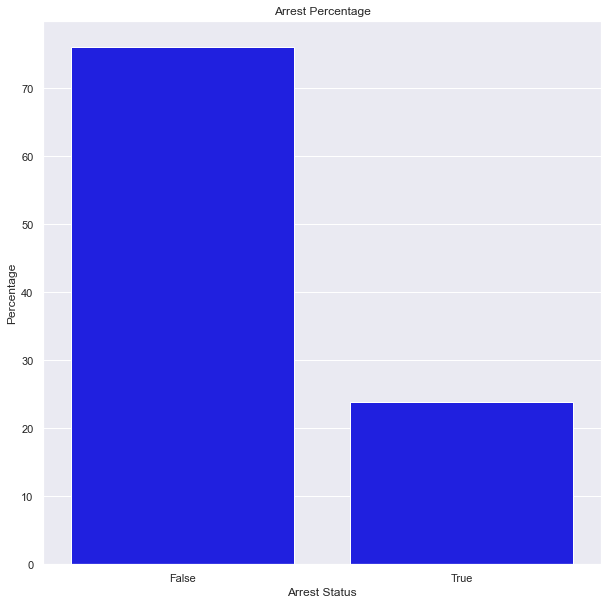

In [134]:
#Make a bar chart of the results
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x="Arrest", y = "mean", order = arrest_grp["Arrest"] \
                                            , data = arrest_grp, color = "blue")
plt.title("Arrest Percentage")
plt.ylabel("Percentage")
plt.xlabel("Arrest Status")

Nearly a quarter of every crime results in an arrest. This large class imbalance will play a factor later when we start building models to predict arrest. 

### Arrest Percentage By Primary Type

In [129]:
#Group by primary type while summarizing by arrest
crime_grp = chicago_train.groupby("primary_type")["arrest"].aggregate(["mean", "sum"]) \
                                                                .sort_values(by="mean", ascending=False)
crime_grp = crime_grp.reset_index()
#Change it to a percentage
crime_grp["mean"] *= 100
crime_grp

,primary_type,mean,sum
0,PUBLIC INDECENCY,100.0,118
1,GAMBLING,99.800399,3500
2,PROSTITUTION,99.670365,12397
3,NARCOTICS,99.646208,221660
4,LIQUOR LAW VIOLATION,98.67919,3362
5,CONCEALED CARRY LICENSE VIOLATION,96.706587,646
6,INTERFERENCE WITH PUBLIC OFFICER,94.768083,11176
7,OBSCENITY,78.294574,404
8,WEAPONS VIOLATION,74.11598,33997
9,PUBLIC PEACE VIOLATION,71.916804,15698


Text(0.5, 0, 'Percent of Arrest')

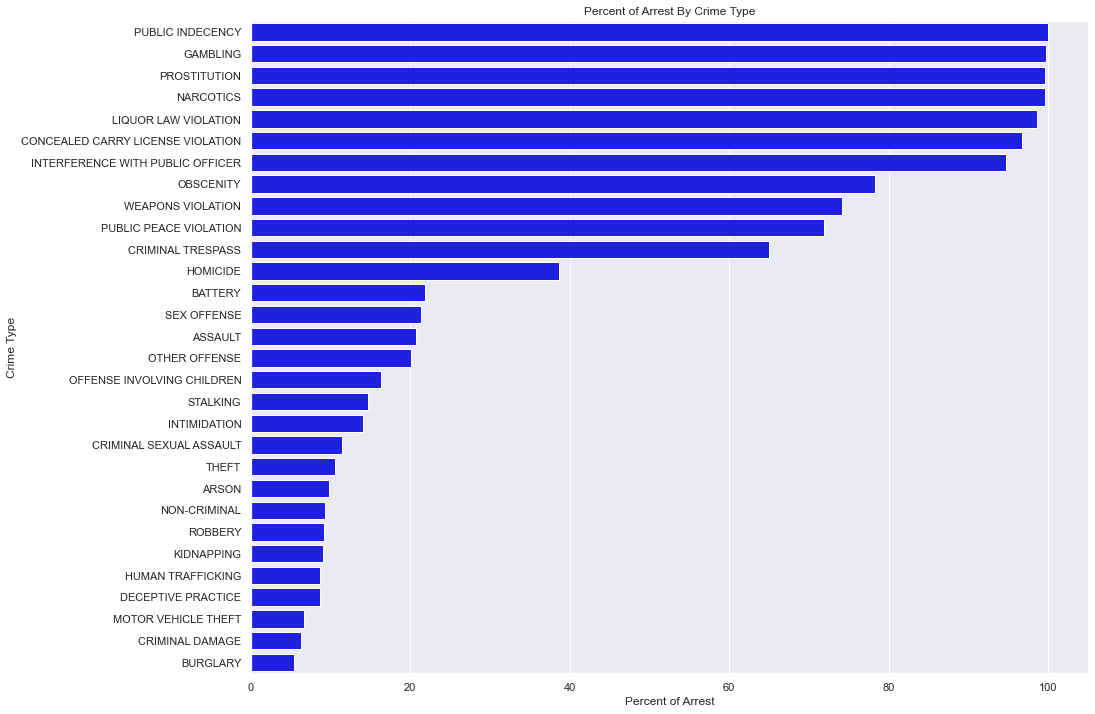

In [135]:
#Make a bar chart showing the results
sns.set(rc = {'figure.figsize':(15,12)})
sns.barplot(x="mean", y = "primary_type", order = crime_grp["primary_type"], data = crime_grp, color = "blue")
plt.title("Percent of Arrest By Crime Type")
plt.ylabel("Crime Type")
plt.xlabel("Percent of Arrest")

Interestingly, Narcotic crimes rank 4th of most occurrences and are also 4th in those crimes resulting in an arrest with an arrest percentage of 99.65%. 

### Arrest Percentage By Location

In [136]:
#Group by location while summarizing by arrest
descrip_grp = chicago_train.groupby("location_description")["arrest"].aggregate(["mean", "sum"]) \
                                                                        .sort_values(by="mean", ascending=False)
descrip_grp = descrip_grp.reset_index()
#Change to percentage
descrip_grp["mean"] *= 100
descrip_grp

,location_description,mean,sum
0,POLICE,66.689737,6745
1,SIDEWALK,45.96744,127624
2,ALLEY,42.081417,24985
3,STORE,38.10558,66676
4,BUILDING,36.424434,6100
5,GAS STATION,36.24641,12115
6,VACANT,35.206672,3884
7,LIBRARY,32.337714,812
8,PARK PROPERTY,31.982863,6868
9,VEHICLE,29.884435,17119


Text(0.5, 0, 'Percent of Arrest')

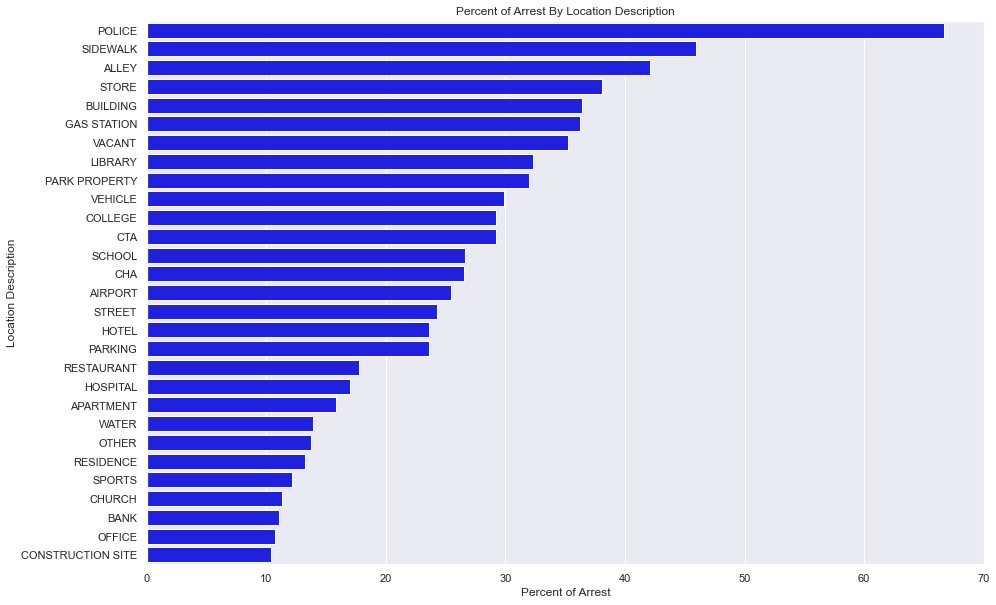

In [137]:
#Make a bar chart of the results
sns.set(rc = {'figure.figsize':(15,10)})
sns.barplot(x="mean", y = "location_description", order = descrip_grp["location_description"] \
                                            , data = descrip_grp, color = "blue")
plt.title("Percent of Arrest By Location Description")
plt.ylabel("Location Description")
plt.xlabel("Percent of Arrest")

It should be no surprise that the police location has the highest arrest percentage at 66.69%. What is surprising is that the bank location has such a low arrest percentage at only 11.04% with the numerous security measures in place.

### Arrest Percentage By Month

In [138]:
#Group by month while summarizing by arrest
month_grp = chicago_train.groupby("Month")["arrest"].aggregate(["mean", "sum"])
month_grp = month_grp.reset_index()
#Change to percentage
month_grp["mean"] *= 100
month_grp

,Month,mean,sum
0,1,25.346166,56489
1,2,27.038472,52423
2,3,26.31062,59738
3,4,24.718405,55455
4,5,24.135185,60609
5,6,23.172975,58569
6,7,23.132918,61079
7,8,23.004397,60119
8,9,23.168652,55839
9,10,22.63928,54416


Text(0.5, 0, 'Month')

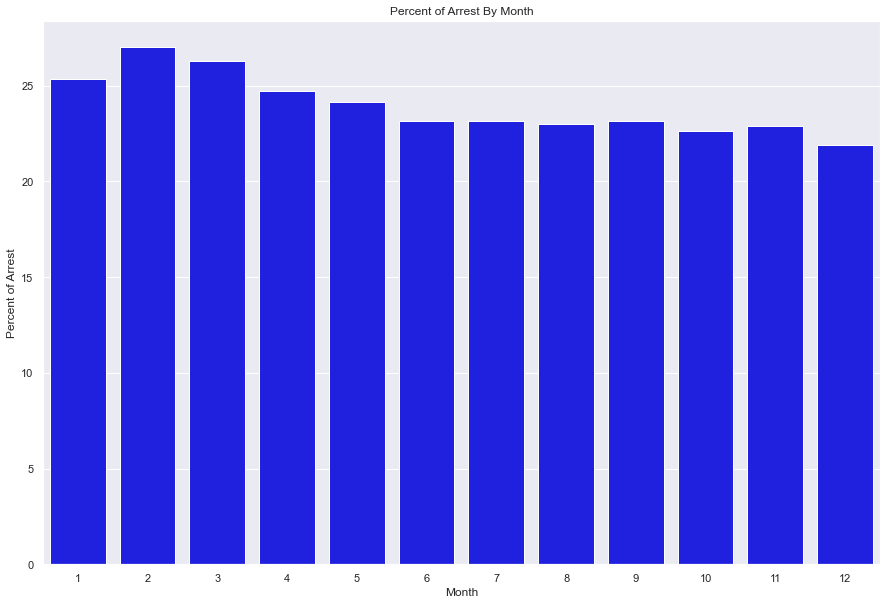

In [139]:
#Make a bar chart of the results
sns.set(rc = {'figure.figsize':(15,10)})
sns.barplot(x="Month", y = "mean", order = month_grp["Month"] \
                                            , data = month_grp, color = "blue")
plt.title("Percent of Arrest By Month")
plt.ylabel("Percent of Arrest")
plt.xlabel("Month")

We see that the first few months have the highest arrest percentage compared to the end of the year.

### Arrest Percentage By Hour

In [149]:
#Group by Hour while summarizing by Arrest
hour_grp = chicago_train.groupby("Hour")["arrest"].aggregate(["mean", "sum"])
hour_grp = hour_grp.reset_index()
#Change to a percentage
hour_grp["mean"] *= 100
hour_grp

,Hour,mean,sum
0,0,19.375899,27600
1,1,23.391051,19939
2,2,21.270268,15519
3,3,18.817624,11322
4,4,16.385735,7563
5,5,13.201419,5284
6,6,18.085595,8663
7,7,15.620968,10412
8,8,16.594596,16348
9,9,16.002546,20867


Text(0.5, 0, 'Hour')

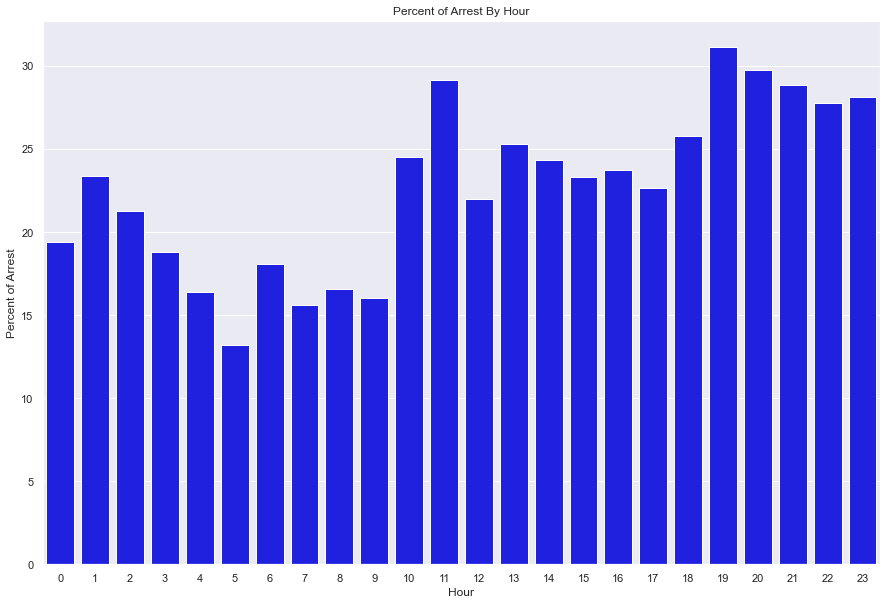

In [150]:
sns.set(rc = {'figure.figsize':(15,10)})
sns.barplot(x="Hour", y = "mean", order = hour_grp["Hour"] \
                                            , data = hour_grp, color = "blue")
plt.title("Percent of Arrest By Hour")
plt.ylabel("Percent of Arrest")
plt.xlabel("Hour")

We see that there are large discrepancies for the arrest percentage by hour of the day. Let's investigate this seeing if we can find a explanation. We'll look at the two extremes: 5am vs. 7pm. 

### Arrest Percentage By Primary Type Grouped By 5am and 7pm

In [186]:
#Make a boolean mask for the 5th hour
mask = chicago_train["Hour"] == 5

#Group by primary type while summarizing by arrest
crime_grp_5 = chicago_train.loc[mask].groupby("primary_type")["arrest"].aggregate(["mean", "sum"])
crime_grp_5 = crime_grp_5.reset_index()
#Change it to a percentage
crime_grp_5["mean"] *= 100
#Add an Hour column
crime_grp_5["Hour"] = "5am"

#Make a boolean mask for the 19th hour
mask = chicago_train["Hour"] == 19

#Group by primary type while summarizing by arrest
crime_grp_19 = chicago_train.loc[mask].groupby("primary_type")["arrest"].aggregate(["mean", "sum"])
crime_grp_19 = crime_grp_19.reset_index()
#Change it to a percentage
crime_grp_19["mean"] *= 100
crime_grp_19["Hour"] = "7pm"
#crime_grp_19

#Concat the two data frames
crime_grp_hour = pd.concat([crime_grp_5, crime_grp_19])
#Sort by arrest percentage
crime_grp_hour.sort_values(by="mean", ascending = False, inplace=True)
crime_grp_hour

,primary_type,mean,sum,Hour
14,LIQUOR LAW VIOLATION,100.0,10,5am
4,CONCEALED CARRY LICENSE VIOLATION,100.0,23,5am
23,PUBLIC INDECENCY,100.0,5,7pm
21,PUBLIC INDECENCY,100.0,1,5am
20,PROSTITUTION,100.0,164,5am
4,CONCEALED CARRY LICENSE VIOLATION,100.0,42,7pm
17,NARCOTICS,99.782187,21073,7pm
22,PROSTITUTION,99.7003,998,7pm
9,GAMBLING,99.371069,474,7pm
15,LIQUOR LAW VIOLATION,99.0,297,7pm


Text(0.5, 0, 'Percent of Arrest')

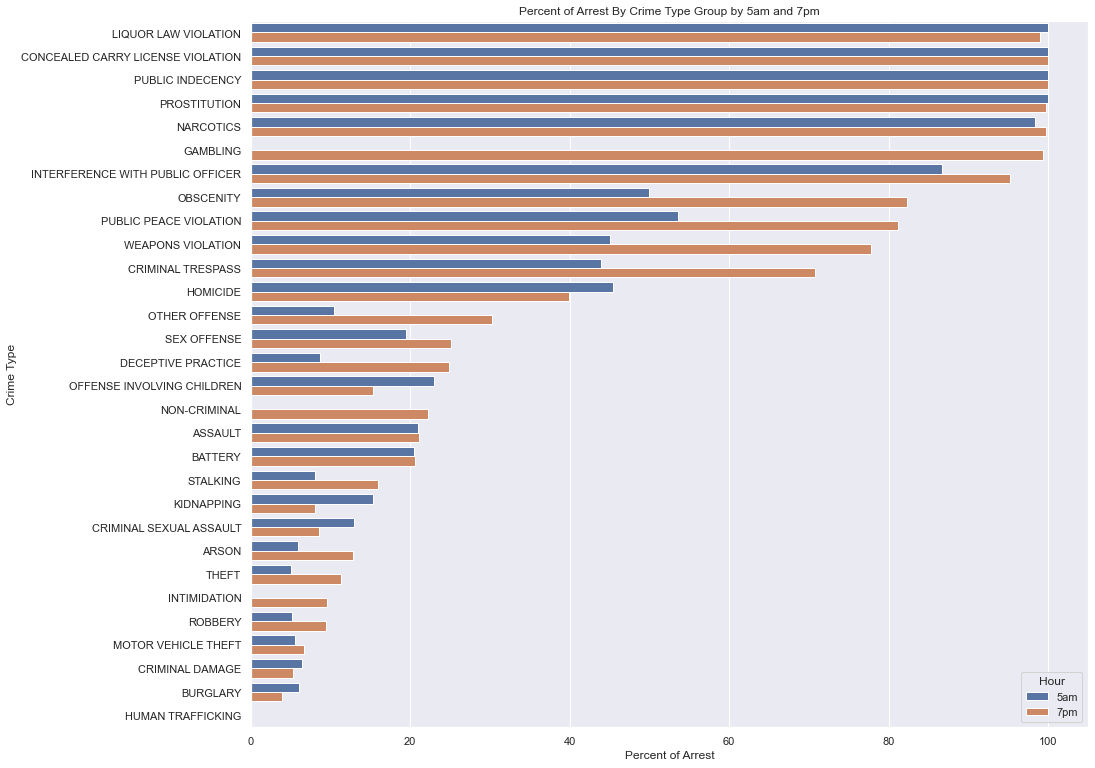

In [198]:
#Make a bar chart showing the results
sns.set(rc = {'figure.figsize':(15,13)})
sns.barplot(x="mean", y = "primary_type", data = crime_grp_hour, hue = "Hour")
plt.title("Percent of Arrest By Crime Type Grouped by 5am and 7pm")
plt.ylabel("Crime Type")
plt.xlabel("Percent of Arrest")

### Arrest Percentage By Location Grouped By 5am and 7pm

In [190]:
#Make a boolean mask for the 5th hour
mask = chicago_train["Hour"] == 5

#Group by primary type while summarizing by arrest
loc_grp_5 = chicago_train.loc[mask].groupby("location_description")["arrest"].aggregate(["mean", "sum"])
loc_grp_5 = loc_grp_5.reset_index()
#Change it to a percentage
loc_grp_5["mean"] *= 100
#Add an Hour column
loc_grp_5["Hour"] = "5am"

#Make a boolean mask for the 19th hour
mask = chicago_train["Hour"] == 19

#Group by primary type while summarizing by arrest
loc_grp_19 = chicago_train.loc[mask].groupby("location_description")["arrest"].aggregate(["mean", "sum"])
loc_grp_19 = loc_grp_19.reset_index()
#Change it to a percentage
loc_grp_19["mean"] *= 100
loc_grp_19["Hour"] = "7pm"

#Concat the two data frames
loc_grp_hour = pd.concat([loc_grp_5, loc_grp_19])
#Sort by arrest percentage
loc_grp_hour.sort_values(by="mean", ascending = False, inplace=True)
loc_grp_hour

,location_description,mean,sum,Hour
18,POLICE,61.870504,86,5am
26,VACANT,57.410882,306,7pm
22,SIDEWALK,56.372003,11638,7pm
18,POLICE,55.802469,226,7pm
1,ALLEY,52.330258,2212,7pm
13,LIBRARY,50.0,2,5am
10,GAS STATION,47.934678,998,7pm
28,WATER,47.826087,11,5am
4,BUILDING,47.634584,292,7pm
9,CTA,46.712018,1854,7pm


Text(0.5, 0, 'Percent of Arrest')

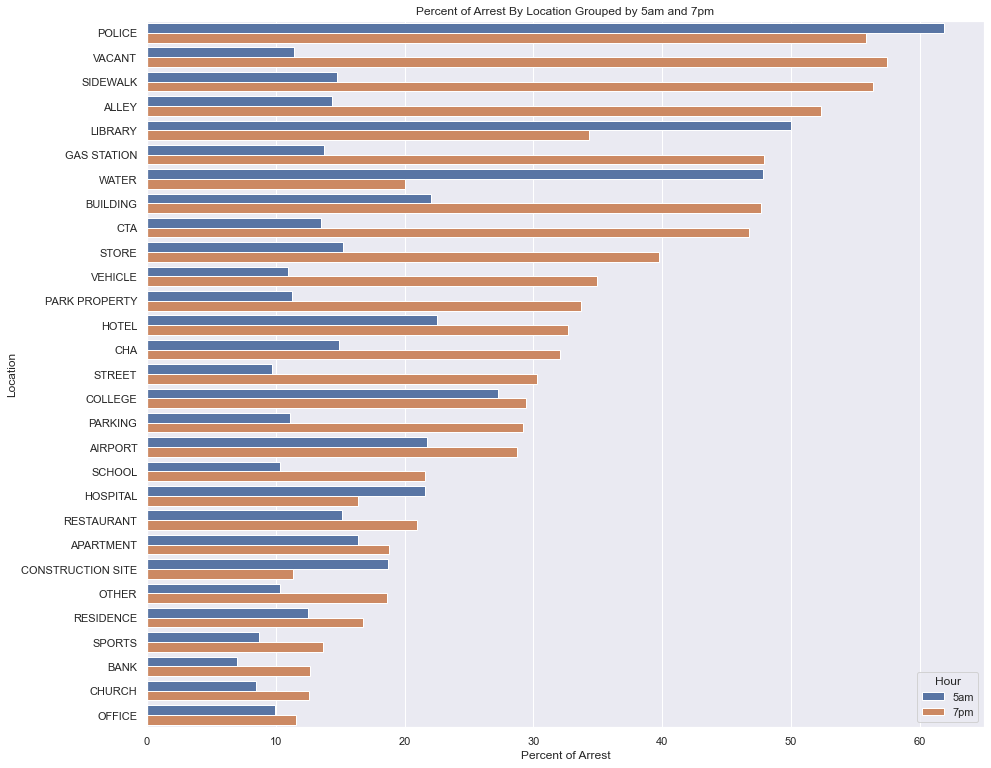

In [199]:
#Make a bar chart showing the results
sns.set(rc = {'figure.figsize':(15,13)})
sns.barplot(x="mean", y = "location_description", data = loc_grp_hour, hue = "Hour")
plt.title("Percent of Arrest By Location Grouped by 5am and 7pm")
plt.ylabel("Location")
plt.xlabel("Percent of Arrest")

It's important to correctly disect what is happening in both of these graphs. At first glance, it may seem that 7pm simply has more occurrences of each crime or location compared to 5am. That may be true but that's not what is being shown. What is being shown is that given the a crime occured at a "VACANT" location, the arrest percentage at 7pm is 57.41% compared to 11.39% for example. Therefore, for nearly every crime and location 7pm makes more arrests than 5am. This is probably because there are more officers working but the data does not provide the information to conclude that claim.  

### Arrest Percentage By District

In [200]:
#Group by district while summarizing by arrest
district_grp = chicago_train.groupby("district_name")["arrest"].aggregate(["mean", "sum"]) \
                                                                    .sort_values(by="mean", ascending = False)
district_grp = district_grp.reset_index()
#Change to a percentage
district_grp["mean"] *= 100
district_grp

,district_name,mean,sum
0,West,30.380059,215761
1,Southwest,25.64398,103266
2,Far Southeast,24.422617,81880
3,South,21.928145,82586
4,Far Southwest,21.829679,38940
5,Central,21.049866,44062
6,Far North,19.157742,47261
7,Northwest,18.663929,29179
8,North,14.76052,29391


Text(0.5, 0, 'District')

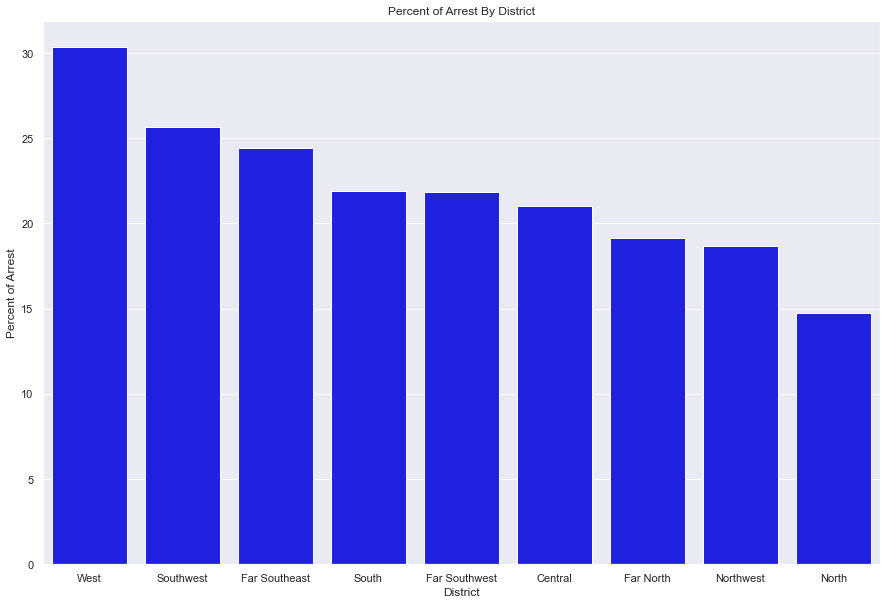

In [201]:
sns.set(rc = {'figure.figsize':(15,10)})
sns.barplot(x="district_name", y = "mean", order = district_grp["district_name"] \
                                            , data = district_grp, color = "blue")
plt.title("Percent of Arrest By District")
plt.ylabel("Percent of Arrest")
plt.xlabel("District")

Again, we see a fairly large discrepancy between the highest district, West, compared to the lowest district, North. Let's see if we can again break this down. 

### Arrest Percentage By Primary Type Grouped By West and North Districts

In [214]:
#Make a boolean mask for the 5th hour
mask = chicago_train["district_name"] == "West"

#Group by primary type while summarizing by arrest
crm_grp_west = chicago_train.loc[mask].groupby("primary_type")["arrest"].aggregate(["mean", "sum"])
crm_grp_west = crm_grp_west.reset_index()
#Change it to a percentage
crm_grp_west["mean"] *= 100
#Add an Hour column
crm_grp_west["District"] = "West"

#Make a boolean mask for the 19th hour
mask = chicago_train["district_name"] == "North"

#Group by primary type while summarizing by arrest
crm_grp_north = chicago_train.loc[mask].groupby("primary_type")["arrest"].aggregate(["mean", "sum"])
crm_grp_north = crm_grp_north.reset_index()
#Change it to a percentage
crm_grp_north["mean"] *= 100
crm_grp_north["District"] = "North"

#Concat the two data frames
crm_grp_dst = pd.concat([crm_grp_west, crm_grp_north])
#Sort by arrest percentage
crm_grp_dst.sort_values(by="mean", ascending = False, inplace=True)

Text(0.5, 0, 'Percent of Arrest')

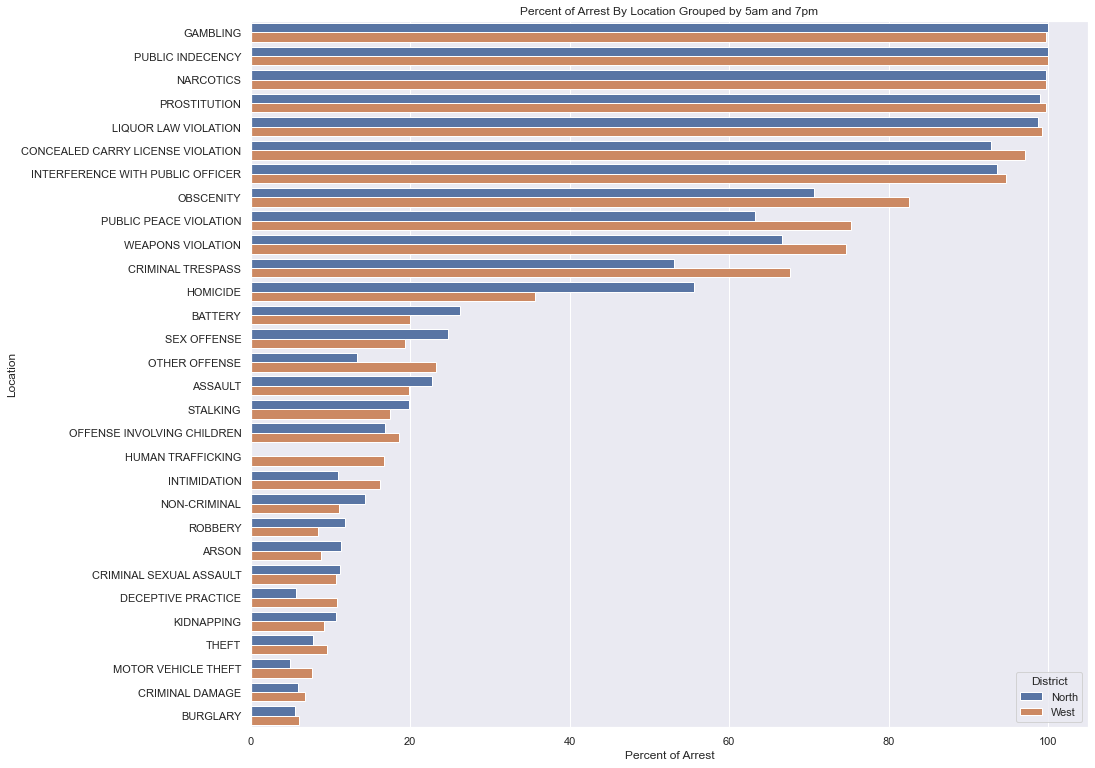

In [209]:
#Make a bar chart showing the results
sns.set(rc = {'figure.figsize':(15,13)})
sns.barplot(x="mean", y = "primary_type", data = crm_grp_dst, hue = "District")
plt.title("Percent of Arrest By Location Grouped by 5am and 7pm")
plt.ylabel("Location")
plt.xlabel("Percent of Arrest")

In [213]:
#Make a boolean mask for the 5th hour
mask = chicago_train["district_name"] == "West"

#Group by primary type while summarizing by arrest
loc_grp_west = chicago_train.loc[mask].groupby("location_description")["arrest"].aggregate(["mean", "sum"])
loc_grp_west = loc_grp_west.reset_index()
#Change it to a percentage
loc_grp_west["mean"] *= 100
#Add an Hour column
loc_grp_west["District"] = "West"

#Make a boolean mask for the 19th hour
mask = chicago_train["district_name"] == "North"

#Group by primary type while summarizing by arrest
loc_grp_north = chicago_train.loc[mask].groupby("location_description")["arrest"].aggregate(["mean", "sum"])
loc_grp_north = loc_grp_north.reset_index()
#Change it to a percentage
loc_grp_north["mean"] *= 100
loc_grp_north["District"] = "North"

#Concat the two data frames
loc_grp_dst = pd.concat([loc_grp_west, loc_grp_north])
#Sort by arrest percentage
loc_grp_dst.sort_values(by="mean", ascending = False, inplace=True)

Text(0.5, 0, 'Percent of Arrest')

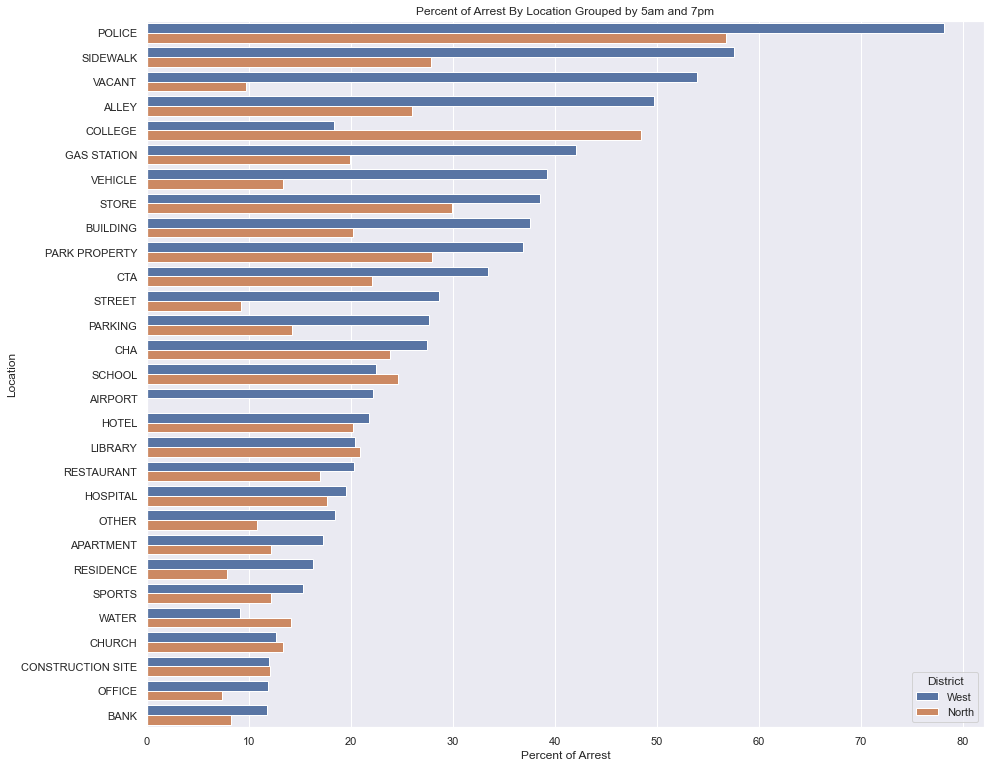

In [212]:
#Make a bar chart showing the results
sns.set(rc = {'figure.figsize':(15,13)})
sns.barplot(x="mean", y = "location_description", data = loc_grp_dst, hue = "District")
plt.title("Percent of Arrest By Location Grouped by 5am and 7pm")
plt.ylabel("Location")
plt.xlabel("Percent of Arrest")

We can see that when comparing the arrest status of crime type grouped by the West and North district there is little to no difference. However, when comparing the arrest status of location grouped by the West and North district is when the overall difference between the West and North district becomes apparent. The arrest percentage of the West district for each location is higher than nearly every location of the North district. 

### Arrest Percentage By Community

In [203]:
#Group by Community while summarizing by Arrest
comm_grp = chicago_train.groupby("community_name")["arrest"].aggregate(["mean", "sum"]) \
                                                                    .sort_values(by="mean", ascending = False)
comm_grp = comm_grp.reset_index()
#Change to percentage
comm_grp["mean"] *= 100
#Too many to show all 
comm_grp.head()

,community_name,mean,sum
0,WEST GARFIELD PARK,44.676809,26811
1,NORTH LAWNDALE,36.648161,33337
2,HUMBOLDT PARK,36.615554,32571
3,EAST GARFIELD PARK,35.035908,18685
4,AUSTIN,33.419386,58642


In [204]:
comm_grp.tail()

,community_name,mean,sum
72,BEVERLY,12.093863,1206
73,EDISON PARK,11.824206,339
74,HYDE PARK,11.168098,1938
75,LINCOLN PARK,9.963261,4339
76,FOREST GLEN,9.626492,500


Text(0.5, 0, 'Percent of Arrest')

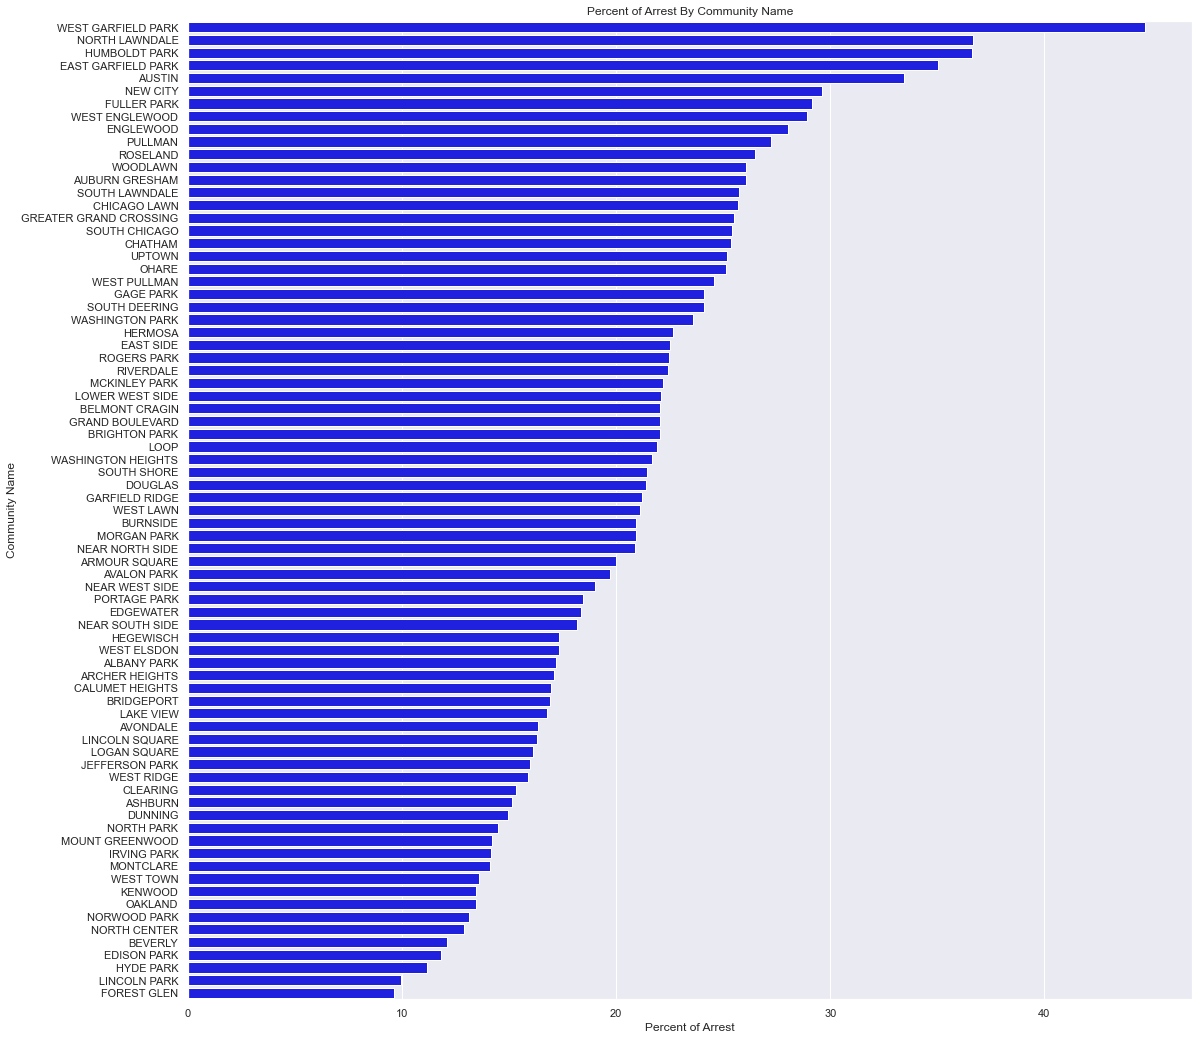

In [205]:
sns.set(rc = {'figure.figsize':(18,18)})
sns.barplot(x="mean", y = "community_name", order = comm_grp["community_name"] \
                                            , data = comm_grp, color = "blue")
plt.title("Percent of Arrest By Community Name")
plt.ylabel("Community Name")
plt.xlabel("Percent of Arrest")

### Arrest Percentage By Domestic

In [206]:
#Group by Domestic while summarizing by Arrest
dom_grp = chicago_train.groupby("domestic")["arrest"].aggregate(["mean", "sum"]) \
                                                                    .sort_values(by="mean", ascending = False)
dom_grp = dom_grp.reset_index()
#Change to percentage
dom_grp["mean"] *= 100
dom_grp

,domestic,mean,sum
0,False,24.900203,591587
1,True,18.399787,80739


Text(0.5, 0, 'Domestic')

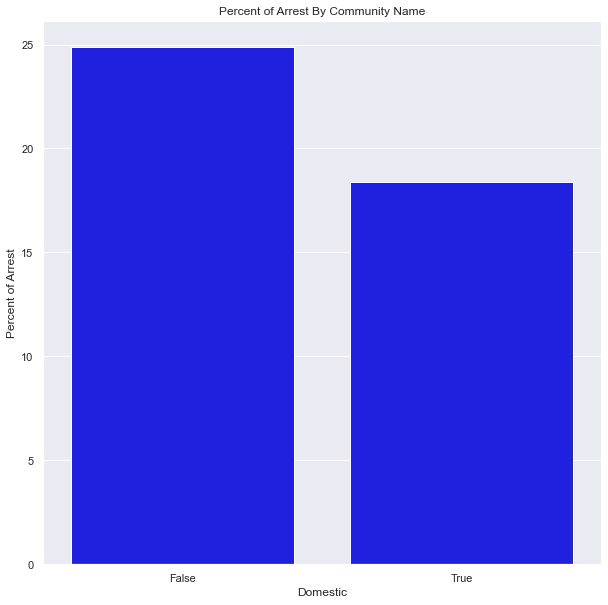

In [207]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x="domestic", y = "mean", order = dom_grp["domestic"] \
                                            , data = dom_grp, color = "blue")
plt.title("Percent of Arrest By Community Name")
plt.ylabel("Percent of Arrest")
plt.xlabel("Domestic")